#### Dedicato a Jack e Marco: ecco in azione l'*Istituto Centrale di Statistica*

In [1]:
%%javascript
// to avoid scroll in windows
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
import random as r
import matplotlib.pyplot as plt
import commonVar as cmv
import numpy as np

### stock-flow *model0*, the real part

- We are considering here uniquely the real part of the economy.

- No loans, credits, debits, capital stock, interest rate

- Enterpreneurs have unlimited funds that they put freely in their activities.

- Saving is abstension from consuming.

### symbols

[symbol table](https://www.caam.rice.edu/~heinken/latex/symbols.pdf) in $\LaTeX$ 

$\mathcal{N}$ - number of agents, `agentNum`

$\mathcal{E}$ - employer number, a uniformly distributed integer number in range $[\mathcal{E}_{min},\mathcal{E}_{max}]$, `employerNum`

$p$ - price `price`

$u$ - unemployment rate `unemploymentRate`

$dimensional~etherogeneity$ is a $true/false$ chooser, forcing increasing firms to attract more workers. `dimensionalEtherogeneity`

$\pi_{i,t}$ - labor productivity, a uniformly distributed decimal number in range $[\pi_{min},\pi_{max}]$,`productivity`

$\Delta\pi_{i,t}$ - uniperiodal additive productivity correction in range $[\Delta\pi_{min},\Delta\pi_{max}]$, `productivityDelta`

$n_{i,t}$ - number of workers in a firm, set just in time

$q_{i,t}$ - production in quantity, `production`

$\Pi_{i,t}$ - profit, `profit`

$w$ - wage `wage`

$r_{i,t}$ - revenues, `revenues`

$s_{i,t}$ - sales, `sales`

$v_{i,t}$ - in**v**entories (final, initial), `initialInventories`, `finalInventories`

$d_{i}$ - deperibility share of the production, `deperibilityShare`, setting $d_{max}$

$c_{i,t}$ - consumption rate, a uniformly distributed decimal number in range $[c_{min},c_{max}]$,`consumptionRate`

$C_{i,t}$ - consumption of $i$ in $t$

$T$ - number of cycles `ncycles`

$t$ - cycle `cycle`
 

### model parameters

In [16]:
cmv.agentNum=100
employerMin=5
employerMax=20

cmv.price=1

cmv.unemploymentRate=0
cmv.dimensionalEtherogeneity=True

cmv.productivityMin=0.8
cmv.productivityMax=1.2
cmv.productivityDeltaMin=cmv.productivityMin-1
cmv.productivityDeltaMax=cmv.productivityMax-1

cmv.maxDeperibilityShare=0.5

cmv.wage=1
cmv.consumptionRateMin=0.5
cmv.consumptionRateMax=1

cmv.nOfConsumptionActions=20
cmv.ncycles=100
cmv.cycle=0

### agent structure

The structure of a generic agent: it can represent and employer, a worker, an unemployed person.

When an agent is created, the **initialization process** defines:

- its numerical id, `num`

- its employer status, `employer`, set to $false$
- the id of its employer, `myEmployer`, set to $0$
- $r_{i,0}$ - `revenues`, initial value  $0$
- $s_{i,0}$ - `sales`, , initial value  $0$
- $v_{i,0}$ - inventories, `initialInventories`, set to $0$ 
- $d_{i}$ - deperibility share, a uniformly distributed decimal number in range $[0,d_{max}]$,`deperibilityShare`
- $w$ - `wage`, currently a fixed value



each agent has the functions:

- **produce** function, used only if is an employer, with:

  $\pi_{i,t}=\pi_{i,t-1}+\Delta\pi_{i,t}$

  $q_{i,t}=n_{i,t} \pi_{i,t}$
  

- **payWages**

  if employer, increases the wallet of each employee of the amount $w$ in each time $t$
  

- **buyConsumptionGoods** 

  $C_{i,t}=c_{i,t} (w+\Pi_{i,t-1})$



In [4]:
class Agent():
    def __init__(self, num):
        self.num=num
        self.employer=False
        self.myEmployer=0
        self.revenues=0 #sales*price
        self.sales=0
        self.initialInventories=0
        self.deperibilityShare=r.uniform(0,cmv.maxDeperibilityShare)
        self.wallet=0
        self.consumptionRate=0
        self.profit=0

    def produce(self):
        self.productivity+=r.uniform(cmv.productivityDeltaMin,cmv.productivityDeltaMax)
        self.production=len(self.myWorkers)*self.productivity
    
    def payWages(self):
        for anAgent in self.myWorkers:
            anAgent.wallet+=cmv.wage
            
    def buyConsumptionGoods(self,k):
        if k==0: 
            self.consumptionRate=r.uniform(cmv.consumptionRateMin,cmv.consumptionRateMax)
            self.consumption=(cmv.wage+self.profit)*self.consumptionRate
            if self.consumption < 0: self.consumption=0
    
    def makeBalanceSheet(self):
        lostProduction=0
        if self.production - self.sales > 0: 
            lostProduction=(self.production - self.sales)*self.deperibilityShare
        self.finalInventories=self.initialInventories+self.production-\
                              self.sales-lostProduction
        self.revenues=self.sales*cmv.price
        self.profit=self.revenues - len(self.myWorkers)*cmv.wage + \
          (self.finalInventories-self.initialInventories)*cmv.price
        self.wallet+=self.profit
        


### agent setup

In [5]:
def setup():
    cmv.employerNum=r.randint(employerMin, employerMax)
    cmv.agentList=[]
    for n in range(cmv.agentNum):
        anAgent=Agent(n+1)
        cmv.agentList.append(anAgent)
    

    # creation of employer list
    employerCandidates=cmv.agentList.copy()

    for n in range(cmv.employerNum):
        i=r.randint(0,len(employerCandidates))
        employerCandidates[i].employer=True
        employerCandidates[i].myEmployer=employerCandidates[i]
        employerCandidates[i].myWorkers=[employerCandidates[i]]
        employerCandidates[i].productivity=r.uniform(cmv.productivityMin,cmv.productivityMax)
        employerCandidates.pop(i)
      

    # creation of workforce list
    toBeEmployed=[]

    for anAgent in cmv.agentList:
        if not anAgent.employer: toBeEmployed.append(anAgent)
    for k in range(round(cmv.unemploymentRate*cmv.agentNum)):
        toBeEmployed.pop(r.randint(0,len(toBeEmployed)))
    #len(toBeEmployed)


    # assigning workforce to employers
    tmpEmployerListWithDuplications=[]
    for anAgent in cmv.agentList:
        if anAgent.employer: tmpEmployerListWithDuplications.append(anAgent)
    for anAgent in toBeEmployed:
        choice=r.choice(tmpEmployerListWithDuplications)
        anAgent.myEmployer=choice
        choice.myWorkers.append(anAgent)
        if cmv.dimensionalEtherogeneity: tmpEmployerListWithDuplications.append(choice)
            
    cmv.totalProductionSeries=[]
    cmv.totalProductionInfraVarSeries=[]
    cmv.totalProfitSeries=[]
    cmv.totalProfitInfraVarSeries=[]


### ------------------------------------------------------------------

In [6]:
def produceAll():
    cmv.totalProductionSeries.append(0)
    cmv.totalProductionInfraVarSeries.append(0)
    for anAgent in cmv.agentList:
        if anAgent.employer: 
            anAgent.produce()
            cmv.totalProductionSeries[-1]+=anAgent.production
            cmv.totalProductionInfraVarSeries[-1]+=anAgent.production**2
    cmv.totalProductionInfraVarSeries[-1]=\
                                  (cmv.totalProductionInfraVarSeries[-1]/cmv.employerNum - \
                                  (cmv.totalProductionSeries[-1]/cmv.employerNum)**2)
                                          

In [7]:
def payWagesAll():
    for anAgent in cmv.agentList:
        if anAgent.employer:
            anAgent.payWages()


In [8]:
def buyConsumptionGoodsAll():
    for k in range(cmv.nOfConsumptionActions):
        r.shuffle(cmv.agentList)
        for anAgent in cmv.agentList:
            anAgent.buyConsumptionGoods(k)

In [9]:
def makeBalanceSheetAll():
    cmv.totalProfitSeries.append(0)
    cmv.totalProfitInfraVarSeries.append(0)
    for anAgent in cmv.agentList:
        if anAgent.employer:
            anAgent.makeBalanceSheet()
            cmv.totalProfitSeries[-1]+=anAgent.profit
            cmv.totalProfitInfraVarSeries[-1]+=anAgent.profit**2
    cmv.totalProfitInfraVarSeries[-1]=(cmv.totalProfitInfraVarSeries[-1]/cmv.employerNum - \
                                          (cmv.totalProfitSeries[-1]/cmv.employerNum)**2)
                                             

In [47]:
def plot1():
    # https://matplotlib.org/3.5.1/gallery/subplots_axes_and_figures/two_scales.html
    # https://matplotlib.org/3.5.1/tutorials/colors/colors.html
    myColor1 = 'tab:orange'
    myColor2 = 'tab:blue'
    fig1, ax1a = plt.subplots()
    ax1a.set_ylim([0, max(cmv.totalProductionSeries)])
    t=range(1,cmv.ncycles+1)
    ax1a.plot(t, cmv.totalProductionSeries, label="production", color=myColor1)
    ax1a.tick_params(axis='y', labelcolor=myColor1)
    
    ax2a = ax1a.twinx()  # instantiate a second axes that shares the same x-axis
    ax2a.set_ylim([0, max(cmv.totalProductionInfraVarSeries)])
    ax2a.plot(t, cmv.totalProductionInfraVarSeries, label="prodInVar", color=myColor2)
    ax2a.tick_params(axis='y', labelcolor=myColor2)
    fig1.legend()

def plot2():
    # https://matplotlib.org/3.5.1/gallery/subplots_axes_and_figures/two_scales.html
    # https://matplotlib.org/3.5.1/tutorials/colors/colors.html
    myColor1 = 'tab:orange'
    myColor2 = 'tab:blue'
    fig2, ax1b = plt.subplots()
    ax1b.set_ylim([min(cmv.totalProfitSeries), max(0,max(cmv.totalProfitSeries))])
    t=range(1,cmv.ncycles+1)
    ax1b.plot(t, cmv.totalProfitSeries, label="profit", color=myColor1)
    ax1b.tick_params(axis='y', labelcolor=myColor1)
    ax1b.plot([0,cmv.ncycles],[0,0],color='tab:green')

    ax2b = ax1b.twinx()  # instantiate a second axes that shares the same x-axis
    ax2b.set_ylim([0, max(cmv.totalProfitInfraVarSeries)])
    ax2b.plot(t, cmv.totalProfitInfraVarSeries, label="profInVar", color=myColor2)
    ax2b.tick_params(axis='y', labelcolor=myColor2)
    fig2.legend()


### model machine

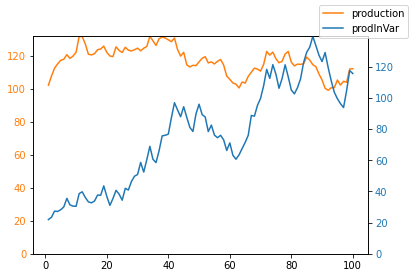

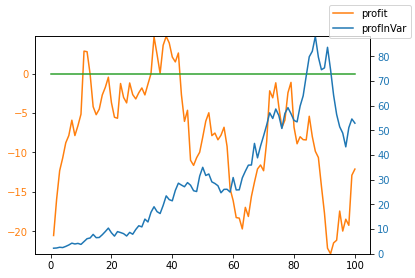

In [48]:
r.seed(121314)

setup()

cmv.actionList=["produceAll()","payWagesAll()","buyConsumptionGoodsAll()",\
                "makeBalanceSheetAll()"]

for cmv.cycle in range(cmv.ncycles):
    for anAction in cmv.actionList:
            exec(anAction)

plot1()
plot2()